In [28]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [29]:
device = 'CM4'

In [30]:
y_true = pd.read_csv('./PrioEval.csv', sep='\t')['class_id'].values

In [31]:
y_true

array([0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1,
       3, 0, 2, 1, 3, 2, 2, 1, 3, 3, 3, 2, 3, 0, 2, 0, 0, 3, 0, 1, 1, 2,
       3, 1, 2, 3, 0, 1, 2, 2, 3, 3, 3, 1, 2, 1, 3, 3, 3, 2, 0, 2, 0, 3,
       3, 3, 1, 3, 3, 2, 0, 2, 0, 0, 3, 3, 1, 2, 1, 3, 2, 2, 0, 0, 1, 3,
       0, 0, 3, 0, 1, 2, 1, 1, 2, 0, 2, 1])

In [32]:
base_model = 'RN50'
with open(f'./CLIP/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

In [34]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity.T, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity.T, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity.T, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(1.0)},
 {'k': 2, 'score': np.float64(1.0)},
 {'k': 3, 'score': np.float64(1.0)}]

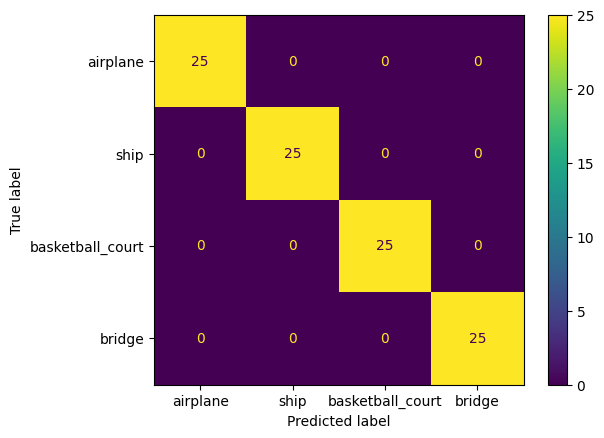

In [35]:
cm = confusion_matrix(y_true, np.argmax(similarity.T, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.show()

In [42]:
base_model = '1280'
with open(f'./YOLO/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

(100, 4)

In [43]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(0.54)},
 {'k': 2, 'score': np.float64(0.89)},
 {'k': 3, 'score': np.float64(0.97)}]

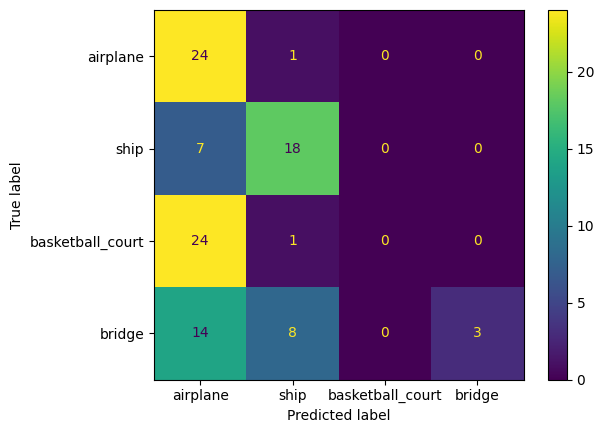

In [44]:
cm = confusion_matrix(y_true, np.argmax(similarity, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.show()

In [41]:
similarity

array([[0.        , 0.27523666, 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.03451364, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.0681119 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.22858378, 1.        , 0.        , 0.        ],
       [0.05637573, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.0387166 , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.0326087 , 0.        , 0.        , 0.        ],
       [0.        , 0.04832202, 0.        , 0.        ],
       [0.03558012, 0.        , 0.        , 0.        ],
       [0.05405352, 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

In [45]:
np.argmax(similarity, axis=1)

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])